# Chapter 4: Statistical Inference
This notebook is about how to infer predictions from a population. It will explore the relationship between _sample parameters_ and _population parameters_, and will propose common statistical inference methods to assess the quality of parameter estimates of sample.

## Data Description
Let's consider a dataset of accidents in Barcelona in 2013 (and later compared 2010). This dataset can be downloaded from [OpenDataBCN](https://opendata.bcn.cat/), Barcelona's City Hall open data service. Each register in the dataset represents an accident by a series of features: weekday, hour, address, number of dead, and number of injured, etc. This dataset will present the population: the set of all reported traffic accidents in Barcelona during 2013.

In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12)

In [ ]:
!wget -O ACCIDENTS_GU_BCN_2013.csv https://raw.githubusercontent.com/DataScienceUB/introduction-datascience-python-book/master/files/ch04/ACCIDENTS_GU_BCN_2013.csv
print('Download complete!')

In [2]:
# read the dataset into a pandas dataframe
data= pd.read_csv('ACCIDENTS_GU_BCN_2013.csv', encoding='latin-1')
print(data.columns)

Index(['Número d'expedient', 'Codi districte', 'Nom districte', 'NK barri',
       'Nom barri', 'Codi carrer', 'Nom carrer', 'Num postal caption',
       'Descripció dia setmana', 'Dia de setmana', 'Descripció tipus dia',
       'NK Any', 'Mes de any', 'Nom mes', 'Dia de mes', 'Hora de dia',
       'Descripció torn', 'Descripció causa vianant', 'Número de morts',
       'Número de lesionats lleus', 'Número de lesionats greus',
       'Número de víctimes', 'Número de vehicles implicats',
       'Coordenada UTM (Y)', 'Coordenada UTM (X)'],
      dtype='object')


In [3]:
data.head()

,Número d'expedient,Codi districte,Nom districte,NK barri,Nom barri,Codi carrer,Nom carrer,Num postal caption,Descripció dia setmana,Dia de setmana,...,Hora de dia,Descripció torn,Descripció causa vianant,Número de morts,Número de lesionats lleus,Número de lesionats greus,Número de víctimes,Número de vehicles implicats,Coordenada UTM (Y),Coordenada UTM (X)
0,2013S007360,-1,Desconegut,-1--1--1,Desconegut,-1,Desconegut,Desconegut,Dimecres,3,...,21,Tarda,Desconegut,0,1,0,1,2,-1,-1
1,2013S007723,10,Sant Martí,101-10-64,el Camp de l'Arpa del Clot,152600,Guinardó,0028 0032,Dimarts,2,...,21,Tarda,Desconegut,0,1,0,1,2,"4585218,67","431621,41"
2,2013S005373,10,Sant Martí,101-10-64,el Camp de l'Arpa del Clot,134801,Freser,0053 0053,Dimarts,2,...,10,Matí,Creuar per fora pas de vianants,0,1,0,1,1,"4585049,89","431605,09"
3,2013S001486,10,Sant Martí,101-10-64,el Camp de l'Arpa del Clot,161407,Indústria,0224 0224,Dimarts,2,...,10,Matí,Altres,0,1,0,1,1,"4584836,20","431302,26"
4,2013S008254,10,Sant Martí,101-10-64,el Camp de l'Arpa del Clot,161101,Independència,0357 0357,Dilluns,1,...,16,Tarda,Desconegut,0,1,0,1,2,"4584704,26","431385,76"


Create a new DataFrame which is the date and the number of accidents on that day. 

In [4]:
# create a new column date
data['Date']='2013-'+data['Mes de any'].apply(lambda x: str(x)) + '-' + data['Dia de mes'].apply(lambda x: str(x))
data['Date']= pd.to_datetime(data['Date'])
accidents = data.groupby('Date').size()
print('Mean:', accidents.mean())

Mean: 25.90958904109589


Suppose we are interested in describing the number of daily traffic accidents (__accident rate__) in the street of Barcelona during 2013. In order to get an impression of the data, we can plot the number of accidents for each day of 2013.  

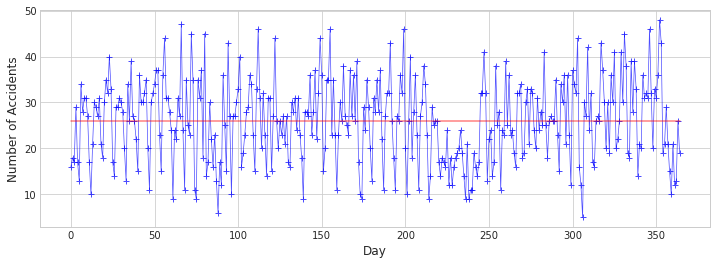

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
plt.ylabel('Number of Accidents')
plt.xlabel('Day')
plt.plot(range(0,365), np.array(accidents), 'b-+', lw=.7, alpha=.7)
plt.plot(range(0,365), [accidents.mean()]*365, 'r-', alpha=.5)
plt.show();

Alternatively, we can plot the distribution of our variable of interest: daily number of accidents.

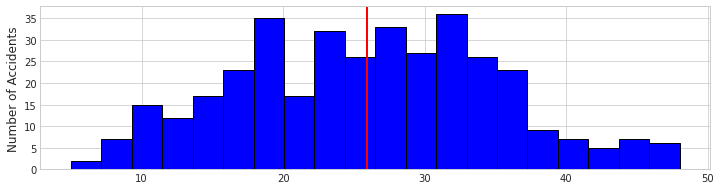

In [6]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.ylabel('Frequency')
plt.ylabel('Number of Accidents')
plt.hist(np.array(accidents), bins=(20), color='b', edgecolor='black')
ax.axvline(x=accidents.mean(), ymin=0, ymax=40, color=[1,0,0], linewidth=2)
plt.show();

If we have access to the whole _population_, the computation of the __accident rate__ in 2013 is a simple operation: the total number of accidents divided by 365 days. As a measure quality of this parameter, we can also compute the standard deviation. 

In [7]:
print('Mean = %.4f'% accidents.mean())
print('STD = %.4f'% accidents.std())

Mean = 25.9096
STD = 9.1083


However, in most real-world datasets, we only have access to a limited part of the data (_the sample_): the number of accidents during some days of 2013. Can we still give an approximation (_an estimate_) to the population parameters? 

## Variability in estimates
Estimates generally vary from one sample to another, and this sampling variation suggests our estimate may be close, but will not be exactly equal to the parameter.

This can be easily checked by generating 10 different, random samples (composed of 25% of the population) from our population and computing their accident rate estimates.

In [8]:
df = accidents.to_frame()
m = []

for i in range (10):
    df['for_testing']=False
    sampled_ids = np.random.choice(df.index,
                                  size=np.int64(np.ceil(df.index.size*0.25)),
                                  replace=False)
    df.loc[sampled_ids, 'for_testing']=True
    accidents_sample= df[df['for_testing']==True]
    m.append(accidents_sample[0].mean())
    print('Sample '+str(i)+': Mean','%.4f'%accidents_sample[0].mean())

Sample 0: Mean 24.7717
Sample 1: Mean 25.9457
Sample 2: Mean 26.3152
Sample 3: Mean 27.8804
Sample 4: Mean 25.2500
Sample 5: Mean 25.4348
Sample 6: Mean 26.2717
Sample 7: Mean 26.1957
Sample 8: Mean 25.0870
Sample 9: Mean 27.6957


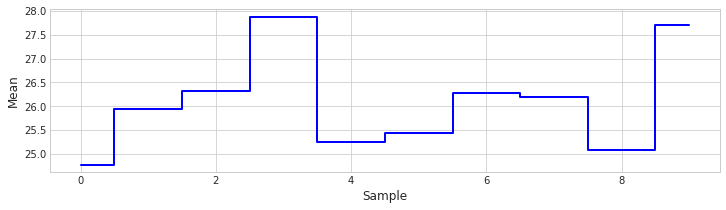

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
x = range(10)
ax.step(x,m,where='mid',color='b',linewidth=2)
ax.set_ylabel('Mean')
ax.set_xlabel('Sample');

Accident rate estimates can range from 24 accidents per day to 28 accidents per day, depending on the sample. But how can we give a unique value for the estimate?

## Sampling distribution of point estimates
The most intuitive way to go about giving a value for the estimate is to simply take the _sample mean_. The sample mean is point estimate of the population mean. If we can only choose one value to estimate the population mean, this would be our best guess.

Let's compute the sample means for set of 10,000 samples, each one composed of 200 days to obtain a robust answer.

Sample Mean: 25.9092


<Figure size 432x288 with 0 Axes>

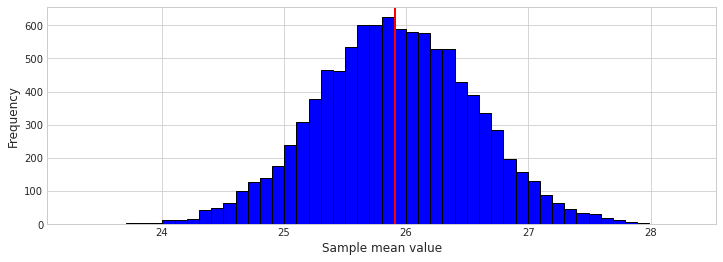

In [10]:
plt.autumn()
# population
df= accidents.to_frame()
N_test = 10000
elements = 200
# mean array of samples
means= [0]*N_test
# sample generation
for i in range(N_test):
    rows= np.random.choice(df.index.values, elements)
    sampled_df= df.loc[rows]
    means[i]= sampled_df.mean()
print('Sample Mean: %.4f'%np.array(means).mean())

fig, ax = plt.subplots(1,1,figsize=(12,4));
plt.hist(np.array(means),bins=50,color='b',edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
ax.axvline(x=np.array(means).mean(),
          ymin=0,
          ymax=700,
          color=[1,0,0],
          linewidth=2)
plt.show();

This is the __sampling distribution of the mean__. From it we could estimate the most probable value of the mean and also its standard deviation, but in the real world, we will not have access to this function! 

## Standard Error (SE) of the mean

Suppose we have only one sample of the population. As mentioned before, the mean estimate from that sample may be close, but not exactly equal to the population parameter of interest. For this reason, it is interesting to measure its variability with respect to the sampling process. To this end, we can use the _standard error of the mean_.

It can be mathematically shown that given $n$ independent observations $x_1,..., x_n$ from a population with a standard deviation of $\sigma_x$, the standard deviation of the sample mean $\sigma_\bar{x}$, or the __standard error__ is:

__SE__ $= \frac{\sigma_x}{\sqrt{n}}$

This allows to __estimate the standard deviation of the sample mean__ even if we cannot perform the simulation process (for instance, because we have no access to the population data). Usually, $\sigma_x$ is not known and it is substituted by its empirical estimate (that is sufficiently good if $n>30$ and the population distribution is not skewed).

In [11]:
rows = np.random.choice(df.index.values, elements)
sampled_df = df.loc[rows]
est_sigma_mean = sampled_df.std()/math.sqrt(elements)
print('Direct estimation of SE from one sample of',elements,'elements: %.4f' %est_sigma_mean[0])
print('Estimation of the SE by simulating 10000 samples of',elements,'elements: %.4f' %np.array(means).std())

Direct estimation of SE from one sample of 200 elements: 0.6513
Estimation of the SE by simulating 10000 samples of 200 elements: 0.6405


Quantifying the standard deviation of other estimates: median, standard deviation, etc. But unlike in the case of sample mean, there is no simple formula for the standard error of other sample estimates, e.g. median.

Let'S consider from the whole accidents dataset as a sample from a hypothetical population (this is the most common situation when analyzing real data).

## Bootstrapping the standard error of the mean
A modern alternative to the traditional approach to statistical inference is the _bootstrapping method_. In the bootstrap, we draw $N$ observations with replacement from the original data to create a bootstrap sample or resample. Then, we can calculate the mean for this resample. By repreating this process a large number of times, we can built a good approximation of the mean sampling distribution.

Define a function __meanBootstrap__ that requires our input variable $X$ and the $numberb$ as the number of times we run the process. 

In [12]:
def meanBootstrap(X,numberb):
    import numpy as np
    x= [0]*numberb
    for i in range(numberb):
        sample= [X[_] for _ in np.random.randint(len(X),size=len(X))]
        x[i]= np.mean(sample)
    return x

In [13]:
m= meanBootstrap(accidents,10000)
print('Mean estimate= %.4f' %np.mean(m))

Mean estimate= 25.9106


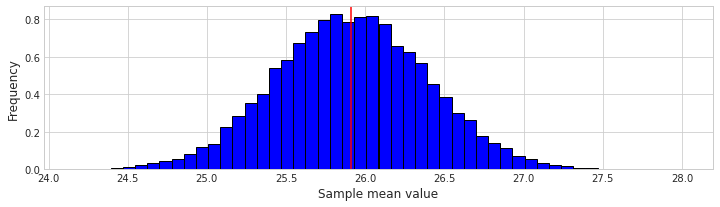

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
plt.hist(m, bins=50, density=True, color='b', edgecolor='black');
ax.axvline(x=np.mean(m), ymin=0.0, ymax=1.0, color=[1,0,0]);

This bootstrapping method can be applied to other simple estimates such as the median or the variance:

In [15]:
def medBootstrap(X,numberb):
    import numpy as np
    x = [0]*numberb
    for i in range(numberb):
        sample = [X[_] for _ in np.random.randint(len(X), size=len(X))]
        x[i] = np.median(sample)
    return x

Median estimate= 26.3012


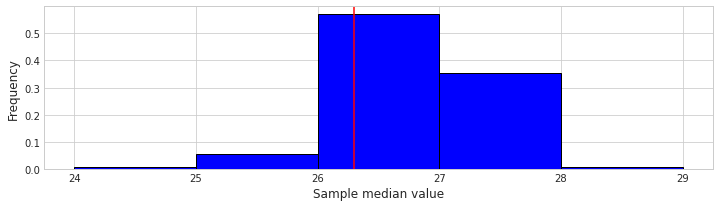

In [16]:
med= medBootstrap(accidents,10000)
print('Median estimate= %.4f'%np.mean(med))
fig, ax= plt.subplots(1,1,figsize=(12,3))
plt.hist(med, bins=5, density=True, color='b', edgecolor='black');
plt.ylabel('Frequency')
plt.xlabel('Sample median value')
ax.axvline(x=np.array(med).mean(),ymin=0.0,ymax=1.0,color=[1,0,0]);

## Confidence Intervals
A point estimate provides a single plausible value for a parameter. However, a point estimate is rarely perfect; usually there is some error in the estimate. That is why we use the standard error as a measure of its variability.

As an alternative, a next logical step is to provide a _plausible range of values_ for the parameter. A plausible range of values for the sample parameter is called a __confidence interval__.

The definition of confidence interval is based on two ideas:
* Our point estimate is the most plausible value of the parameter, so it males sense to build the confidence interval around the point estimate.
* The plausibility of a range of values can be defined from the sampling distribuion of the estimate.

In order to define an interval, we can make use of a well-known result from probability that apploed to normal distribuions: _roughly 95% of the time, our be within 1.96 standard errors of the true mean of the distribuions_.

__CI__ $= [\Theta - 1.96 * SE,\Theta + 1.96 * SE ]$

| Confidence Level | z-Value |
|------------------|---------|
| 90% | 1.65 |
| 95% | 1.96 |
| 99% | 2.58 |
| 99.9% | 3.291 |

In [17]:
m= accidents.mean()
se= accidents.std()/math.sqrt(len(accidents))
ci= [m-se*1.96, m+se*1.96]
print('Confidence Intervals:', np.round(ci, 4))

Confidence Intervals: [24.9752 26.844 ]


This is how to compute a 95% confidence interval of the sample mean by using bootstrapping:
1. Repeat the following steps a large number $M$ of times:
     * Draw $N$ observations with replacement from the original data to create a bootstrap sample or resample;
     * Calculate the mean for the resample.
2. Calculate the __mean__ of your $M$ values of the sample statistic. This process gives you a "bootstrapped" estimate of the sample statistic.
3. Calculate the __standard deviation__ of your $M$ values of the sample statistic. This process gives you "bootstrapped" estimate of the __SE__ of the sample statistic.
4. Obtain the 2.5th and 97.5th percentiles of your $M$ values of the sample statistic.

In [20]:
m= meanBootstrap(accidents,10000)
sample_mean= np.mean(m)
sample_se= np.std(m)
print('Mean estimate: %.4f'% sample_mean)
print('SE of the estimate: %.4f'% sample_se)

ci= [np.percentile(m,2.5), np.percentile(m,97.5)]
print('Confidence Interval: ', np.round(ci, 4))

Mean estimate: 25.9148
SE of the estimate: 0.4765
Confidence Interval:  [24.9699 26.8521]


## What is the real meaning of Confidence Intervals?
The real meaning of "confidence" is not evident and it must be understood from the point of view of the generating process.

Suppose we take many (infinte) samples from a population and built a 95% confidence interval from each sample. Then, about 95% of those intervals would contain the actual parameter.

This can shown by simulating a large number of samples and checking how many intervals contain the true parameter:

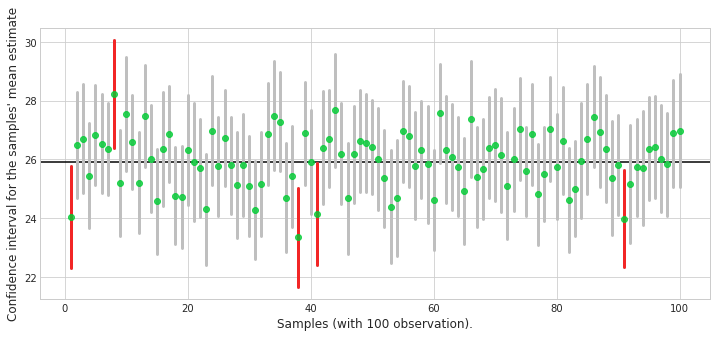

In [21]:
df=accidents
n= 100              # number of observations
N_test= 100         # number of samples with n observations
means= np.array([0.0]*N_test)    # samples' mean
s= np.array([0.0]*N_test)        # samples' std
ci= np.array([[0.0,0.0]]*N_test)
tm= df.mean()                    # 'true' mean

for i in range(N_test):          # sample generation
    rows= np.random.choice(df.index.values, n)
    sampled_df= df.loc[rows]
    means[i]= sampled_df.mean()
    s[i]= sampled_df.std()
    ci[i]= means[i] + np.array([-s[i] *1.96/np.sqrt(n), s[i] *1.96/np.sqrt(n)])

out1= ci[:,0] > tm               # CI that do not contain the true mean
out2= ci[:,1] < tm

fig, ax= plt.subplots(1,1,figsize=(12,5))
ind= np.arange(1,N_test+1)
ax.axhline(y=tm, xmin=0, xmax=N_test+1, color=[0,0,0])
ci= np.transpose(ci)
ax.plot([ind,ind],
       ci,
       color='0.75',
       marker='_',
       ms=0,
       linewidth=3)
ax.plot([ind[out1],ind[out1]],
       ci[:, out1],
       color=[1,0,0,0.8],
       marker='_',
       ms=0,
       linewidth=3)
ax.plot([ind[out2],ind[out2]],
       ci[:, out2],
       color=[1,0,0,0.8],
       marker='_',
       ms=0,
       linewidth=3)
ax.plot(ind,
        means, 
        color=[0,0.8,0.2,0.8],
        marker='.',
        ms=12,
        linestyle='')
ax.set_ylabel('Confidence interval for the samples\' mean estimate', fontsize=12)
ax.set_xlabel('Samples (with %d observation).' %n, fontsize=12)
plt.show();

Understanding the CI Plot:
* the black horizontal line represent the "true mean" of the population
* the grey vertical lines represent the CI of different samples each with 100 observations
* the green point these lines represent their individual mean
* if the CI lines interset with "true mean"-line, then the confidence interval includes the true mean (95 out of 100)
* the red horizontal lines highlight, where this condition is not met (5 out of 100)
* this proves that roughly 95% of those intervals do contain the actual parameter

## Hypothesis Testing
To give a measure of variability of our estimates is a way of producing a statistical proposition about the population, but not the only one. R.A.Fisher (1890-1962) proposed an alternative, known as hypothesis testing, that is based on the concept of _statistical significance_.

Let's suppose that a deeper analysis of traffic accidents in Barcelona results in a difference between 2010 and 2013. Of course, the difference could be caused only by chance, because of the variability of both estimates. But it could also be the case that traffic conditions are very different in Barcelona during these two periods and, because of this, data from these two periods can be considered as belonging to two different populations. Then, the relevant question is: _Are the observed effects real or not?_

The process of determining the statistical significance of an effect is called __hypothesis testing__. This process starts by simplifying the research question into two competing hypotheses:
* $H_0$: The mean number of daily traffic accidents is the same in 2013 and 2010 (there is only one population, one true mean, and 2010 & 2013 are just different samples from the same population).
* $H_1$: The mean number of daily traffic accidents for 2010 and 2013 is different (2010 & 2013 are two samples from two different populations).

We call $H_0$ the _null hypothesis_ and it represents a skeptical point of view: the effect we have observed is due to change (due to the specific sample bias).

$H_A$ is called the _alternative hypothesis_ and represents the other point of view: the effect is real.

The general rule of frequentist hypothesis testing is: We will not discard $H_0$ (and hence will not consider $H_A$) unless the observed effect is implausible under $H_0$.

### Testing hypothesis using confidence intervals
We can use the concept represented by confidence intervals to measure the plausibility of a hypothesis.

We can illustrate the evaluation of the hypotheses setup by comparing the mean rate of traffic accidents in Barcelona during 2010 and 2013 using a point estimate from 2013 sample: 

In [ ]:
!wget -O ACCIDENTS_GU_BCN_2010.csv https://raw.githubusercontent.com/DataScienceUB/introduction-datascience-python-book/master/files/ch04/ACCIDENTS_GU_BCN_2010.csv
print('Download complete!')

Create two DataFrames that have the day and its accident count for each year respectively.  

In [22]:
data= pd.read_csv('ACCIDENTS_GU_BCN_2010.csv', encoding='latin-1')
data['Date']=data['Dia de mes'].apply(lambda x: str(x)) + '-' + data['Mes de any'].apply(lambda x: str(x))

data2= data['Date']
counts2010= data['Date'].value_counts()
print('2010 Mean: %.4f'% counts2010.mean())

data= pd.read_csv('ACCIDENTS_GU_BCN_2013.csv', encoding='latin-1')
data['Date']=data['Dia de mes'].apply(lambda x: str(x)) + '-' + data['Mes de any'].apply(lambda x: str(x))
data2= data['Date']
counts2013= data['Date'].value_counts()
print('2014 Mean: %.4f'% counts2013.mean())

2010 Mean: 24.8110
2014 Mean: 25.9096


This estimate suggests that during 2013 the mean rate of traffic accidents in Barcelona __was higher__ than 2010. Hypothesis testing is asking: But is this effect statistically significant?

Based on our sample, the 95% confidence interval for the mean rate of traffic accidents in Barcelona during 2013 can be calculated as:

In [23]:
n= len(counts2013)
mean= counts2013.mean()
s= counts2013.std()
ci= [mean-s*1.96/np.sqrt(n), mean+s*1.96/np.sqrt(n)]
print('2010 accident rate estimate: %.4f'% counts2010.mean())
print('2013 accident rate estimate: %.4f'% counts2013.mean())
print('Confidence Interval for 2013: ', np.round(ci, 4))

2010 accident rate estimate: 24.8110
2013 accident rate estimate: 25.9096
Confidence Interval for 2013:  [24.9752 26.844 ]


Because the 2010 accident rate estimate does not fall in the range of plausible values of 2013, we can say the alternative hypothesis cannot be discarded. That means it cannot be discarted taht during 2013 the mean rate of traffic accidents in Barcelona was higher than during 2010.

### Testing Hypothesis using p-values
A more advanced notion of statistical significance was developed by R.A.Fisher in the 1920's when looking for a test to decide whether variation in crop yields were due to some specific intervention or merely randon factors beyond experimental control. Fisher first assumed that fertilizer caused no difference (null hypothesis) and then calculated $P$, the probability that an observed yield in a fertilized field would occur if fertilizer had no real effect. This probability is called __p-value__.

The p-value is the probability of observing data at least as favorable to the alternative hypothesis as our current data set, if the null hypothesis is true.

To apply a test of hypotheses to our problem, the first step is to quantify the size of the apparent effect by choosing a test statistic. In our case, the apparent effect is a difference in accident rates, so a natural choice for the test statistic is the difference in means between the two periods:

In [24]:
m= len(counts2010)
n= len(counts2013)
p= (counts2013.mean()-counts2010.mean())
print('m: ',m,'n: ',n)
print('mean difference: %.4f'% p)

m:  365 n:  365
mean difference: 1.0986


The second step is to defie a null hypothesis, which is a model of a system based on the assumption that the apparent effect is not real. In our case, the $H_0$ null hypothesis is that there is not difference between the two periods. The $H_A$ alternative hypothesis is that during 2013 the mean rate of traffic accidents in Barcelone was higher than in 2010.

The third step is to compute a p-value, which is the probability of seeing the apparent effect if the null hypothesis is true. In our case, we would compute the absolute difference in means, then compute the probability of seeing a difference as big, or bigger, under the null hypothesis.

Usually, if P is less than 0.05 (the change of fluke is less than 5%) the result is declared statistically significant.

To approximate the p-value, we can follow this procedure:
1. Pool the distributions, generate samples with size $n$ and compute the difference in the mean.
2. Generate samples with size $n$ and compute the difference in the mean.
3. Count how many differences are larger than the observed one.$H_0$

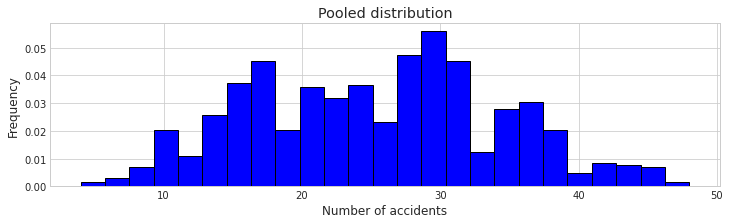

In [25]:
x = counts2010
y = counts2013
pool = np.concatenate([x,y])
np.random.shuffle(pool)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.hist(pool, bins = 25, density=True, color='b', edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Number of accidents')
plt.title("Pooled distribution");

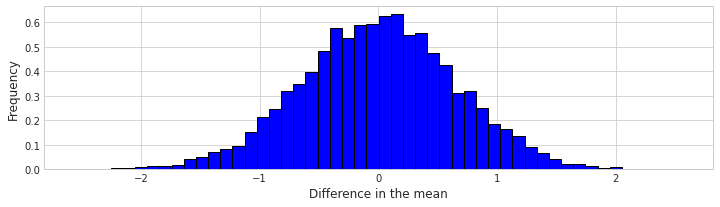

In [26]:
from six.moves import xrange
N= 10000
diff = list(range(N))
for i in range(N):
    p1= [random.choice(pool) for _ in xrange(n)]
    p2= [random.choice(pool) for _ in xrange(n)]
    diff[i] = (np.mean(p1)-np.mean(p2))
    
fig, ax= plt.subplots(1,1,figsize=(12,3))
plt.hist(diff, bins=50, density=True, color='b', edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Difference in the mean');

In [27]:
diff2= np.array(diff)
w1= np.where(diff2> p)[0]
len(w1)

475

If there are $k$ sample pairs where the difference in mean is as big or bigger than 0.05, the p-value is approximately $k/N$. In our case:

In [28]:
print('p_values (Simulation) =', len(w1)/float(N), '(', len(w1)/float(N)*100, '%)', 'Difference = %.4f'% p)
if len(w1)/float(N)<0.05:
    print('The effect is likely')
else:
    print('The effect is unlikely')

p_values (Simulation) = 0.0475 ( 4.75 %) Difference = 1.0986
The effect is likely


We have defined the effect as a difference in mean as big as or bigger than the observed difference, taking into account the significane. A test like this is called _one-sided_.

If the relevant question is whether the accident rates are different, then it makes sense to test the absolute difference in means. This kind of test is called _two-sided_ because it counts both sides of the distribution of differences.

__Source:__

Igual, Laura, and Santi Seguí. "Chapter 4: Statistical Inference." In _Introduction to Data Science_, pp. 51-65. Springer, 2017.

Link to the [original notebook](https://github.com/DataScienceUB/introduction-datascience-python-book/blob/master/ch04_Statistical_Inference.ipynb).